# Structured data

This notebook is a modified version of a [fast.ai notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb) by Jeremy Howard used to show how neural networks can be applied to structured data sets.  The original code has been modified to solve the [Kaggle Titanic challenge](https://www.kaggle.com/c/titanic) which seeks to predict passenger survival based on various properties (such as gender, age, name etc...).  This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

I was interested in seeing how to modify Jeremy's code to handle binary classifications.  I was advised how to do so by this [post](http://forums.fast.ai/t/structured-learner/8224/44) discussing prediction of categorical labels using a neural network given structured data input.  The modification from Jeremy's lecture involved changing the loss metric from root-mean-squared percent error used for a continuous prediction variable to a binary classification using the nll_loss function and changing the last layer in the MixedInputModel to use log_softmax (thanks to Rony Lutsky's [contribution](https://github.com/fastai/fastai/pull/305)).  My submission yielded a fairly average score of 77%, comparable to the random forest regressor.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/titanic/'

## Create datasets

You can download the datasets used [here](https://www.kaggle.com/c/titanic/data).

Feature Space:
* train: Training set provided by competition
* test: testing set

In [6]:
table_names = ['train', 'test']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [7]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [8]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* train: Contains Passenger info such as Gender, Age, Ticket, Fare and whether Survived, the prediction variable
* test: Same as training table, w/o Survived


In [10]:
for t in tables: display(t.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The following returns summarized aggregate information to each table accross each field.

In [11]:
for t in tables: display(DataFrameSummary(t).summary())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891,891,NaN,NaN,714,891,891,NaN,891,NaN,NaN
mean,446,0.383838,2.30864,NaN,NaN,29.6991,0.523008,0.381594,NaN,32.2042,NaN,NaN
std,257.354,0.486592,0.836071,NaN,NaN,14.5265,1.10274,0.806057,NaN,49.6934,NaN,NaN
min,1,0,1,NaN,NaN,0.42,0,0,NaN,0,NaN,NaN
25%,223.5,0,2,NaN,NaN,20.125,0,0,NaN,7.9104,NaN,NaN
50%,446,0,3,NaN,NaN,28,0,0,NaN,14.4542,NaN,NaN
75%,668.5,1,3,NaN,NaN,38,1,0,NaN,31,NaN,NaN
max,891,1,3,NaN,NaN,80,8,6,NaN,512.329,NaN,NaN
counts,891,891,891,891,891,714,891,891,891,891,204,889
uniques,891,2,3,891,2,88,7,7,681,248,147,3


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418,418,NaN,NaN,332,418,418,NaN,417,NaN,NaN
mean,1100.5,2.26555,NaN,NaN,30.2726,0.447368,0.392344,NaN,35.6272,NaN,NaN
std,120.81,0.841838,NaN,NaN,14.1812,0.89676,0.981429,NaN,55.9076,NaN,NaN
min,892,1,NaN,NaN,0.17,0,0,NaN,0,NaN,NaN
25%,996.25,1,NaN,NaN,21,0,0,NaN,7.8958,NaN,NaN
50%,1100.5,3,NaN,NaN,27,0,0,NaN,14.4542,NaN,NaN
75%,1204.75,3,NaN,NaN,39,1,0,NaN,31.5,NaN,NaN
max,1309,3,NaN,NaN,76,8,9,NaN,512.329,NaN,NaN
counts,418,418,418,418,332,418,418,418,417,91,418
uniques,418,3,418,2,79,7,8,363,169,76,3


## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [12]:
train, test = tables

In [13]:
len(train),len(test)

(891, 418)

Do some simple cleanup.  For now, set a constant value for na's (probably not the best choice, but I wanted to do something quickly), remove punctuation and upper case fields.

In [14]:
for df in (train,test):
    df['Age'] = df.Age.fillna(0).astype(np.int32)
    df["Name_mod"] = df["Name"].str.replace('[^\w\s]','')
    df["Ticket_mod"] = df["Ticket"].str.replace('[^\w\s]','')
    df["Name_mod"] = df["Name_mod"].str.upper()
    df["Ticket_mod"] = df["Ticket_mod"].str.upper()
    df["Ticket_mod"]=df["Ticket_mod"].str.upper()
train.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_mod,Ticket_mod
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,BRAUND MR OWEN HARRIS,A5 21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,CUMINGS MRS JOHN BRADLEY FLORENCE BRIGGS THAYER,PC 17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,HEIKKINEN MISS LAINA,STONO2 3101282
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,FUTRELLE MRS JACQUES HEATH LILY MAY PEEL,113803
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,ALLEN MR WILLIAM HENRY,373450


Pull out the person's title from their name

In [15]:
def returnSelectedWord(in_str,selected_words):
	a=in_str.split()
	out = ""
	if any(i in a for i in selected_words):
		out = list(set(a) & set(selected_words))[0]
	return out
	
selected_words = ['MR','MISS','MRS','MASTER','MS','DR'] 
for df in (train,test):
    df["Title"]=df["Name_mod"].apply( lambda x: returnSelectedWord( x,selected_words) )


Pull out the first two characters of the alphabetic and numeric portions of the ticket (it seemed to indicate regions).  Also look at the length of the ticket number.

In [16]:
import re

def returnAlpha(text):
    match = re.search(r'\(?([A-Z]+)\)?', text)
    if match is None:
        return ''
    else:
        return match.group(1)
def returnNumeric(text):
    tmp = text.split()
    text2 =tmp[tmp.__len__()-1]
    match = re.search(r'\(?([0-9]+)\)?', text2)
    if match is None:
        return ''
    else:
        return match.group(1)
for df in (train,test):
    df["Ticket_Alpha_shrt"]=df["Ticket_mod"].apply( lambda x: returnAlpha(x)[:2] )
    df["Ticket_Numeric_shrt"]=df["Ticket_mod"].apply( lambda x: returnNumeric(x)[:2] )
    df["Ticket_Numeric_len"]=df["Ticket_mod"].apply( lambda x: len(returnNumeric(x)) )



Put in a quick hack to prevent log(0).  Also convert the prediction variable to type integer. Separate the alphabetic portion of the Cabin and bin the cabin numbers into categorical variables.

In [19]:
 for df in (train,test):
    df["Fare"]=df["Fare"]+.0001
 train.Survived = train.Survived.astype(int)

In [20]:
for df in (train,test):
    df["Cabin_cnt"]=df["Cabin"].apply(lambda x: '' if pd.isnull(x) else len(x.split()) )
    df["Cabin_mod"]=df["Cabin"].apply(lambda x: '' if pd.isnull(x) else returnAlpha(x)[:2] )
    df["Cabin_num"]=df["Cabin"].apply(lambda x: '' if pd.isnull(x) else returnNumeric(x))
    df["Cabin_num_sm"] = df.Cabin_num.apply(lambda x: -1 if x=='' else str(int(int(x)/10)))
    df["Name_cnt"] = df["Name_mod"].apply(lambda x: 0 if pd.isnull(x) else len(x.split()) )
    df["Fare_log"] = df["Fare"].apply(lambda x: -10.0 if x==0 else math.log(x))

train[["PassengerId","Pclass", "Sex","SibSp","Parch","Title","Ticket_Alpha_shrt","Ticket_Numeric_shrt","Ticket_Numeric_len","Cabin_cnt","Cabin_mod","Cabin_num_sm","Name_cnt","Embarked","Fare","Fare_log","Age","Survived"]].head()

,PassengerId,Pclass,Sex,SibSp,Parch,Title,Ticket_Alpha_shrt,Ticket_Numeric_shrt,Ticket_Numeric_len,Cabin_cnt,Cabin_mod,Cabin_num_sm,Name_cnt,Embarked,Fare,Fare_log,Age,Survived
0,1,3,male,1,0,MR,A,21,5,,,-1,4,S,7.2502,1.981029,22,0
1,2,1,female,1,0,MRS,PC,17,5,1,C,8,7,C,71.2835,4.266665,38,1
2,3,3,female,0,0,MISS,ST,31,7,,,-1,3,S,7.9252,2.070048,26,1
3,4,1,female,1,0,MRS,,11,6,1,C,12,7,S,53.1002,3.972181,35,1
4,5,3,male,0,0,MR,,37,6,,,-1,4,S,8.0502,2.085697,35,0


We fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

## Create features

In [21]:
train.head().T.head(40)

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.2502,71.2835,7.9252,53.1002,8.0502


In [22]:
display(DataFrameSummary(train).summary())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,Ticket_Alpha_shrt,Ticket_Numeric_shrt,Ticket_Numeric_len,Cabin_cnt,Cabin_mod,Cabin_num,Cabin_num_sm,Name_cnt,Fare_log
count,891,891,891,NaN,NaN,891,891,891,NaN,891,...,NaN,NaN,NaN,891,NaN,NaN,NaN,NaN,891,891
mean,446,0.383838,2.30864,NaN,NaN,23.7834,0.523008,0.381594,NaN,32.2044,...,NaN,NaN,NaN,5.34119,NaN,NaN,NaN,NaN,4.06734,2.75047
std,257.354,0.486592,0.836071,NaN,NaN,17.5973,1.10274,0.806057,NaN,49.6934,...,NaN,NaN,NaN,0.960032,NaN,NaN,NaN,NaN,1.16887,1.74317
min,1,0,1,NaN,NaN,0,0,0,NaN,0.0002,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,3,-8.51719
25%,223.5,0,2,NaN,NaN,6,0,0,NaN,7.9106,...,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,3,2.0682
50%,446,0,3,NaN,NaN,24,0,0,NaN,14.4544,...,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,4,2.671
75%,668.5,1,3,NaN,NaN,35,1,0,NaN,31.0002,...,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,4,3.43399
max,891,1,3,NaN,NaN,80,8,6,NaN,512.329,...,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,14,6.23897
counts,891,891,891,891,891,891,891,891,891,891,...,891,891,891,891,891,891,891,891,891,891
uniques,891,2,3,891,2,71,7,7,681,248,...,7,17,51,7,5,9,96,15,8,248


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [23]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,Ticket_Alpha_shrt,Ticket_Numeric_shrt,Ticket_Numeric_len,Cabin_cnt,Cabin_mod,Cabin_num,Cabin_num_sm,Name_cnt,Fare_log
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2502,...,MR,A,21,5,,,,-1,4,1.981029
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2835,...,MRS,PC,17,5,1,C,85,8,7,4.266665
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9252,...,MISS,ST,31,7,,,,-1,3,2.070048
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1002,...,MRS,,11,6,1,C,123,12,7,3.972181
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0502,...,MR,,37,6,,,,-1,4,2.085697


Identify categorical vs continuous variables.  PassengerId serves as the unique identifier for each row.

In [24]:
cat_vars = ["Pclass", "Sex","SibSp","Parch","Title","Ticket_Alpha_shrt","Ticket_Numeric_shrt","Ticket_Numeric_len","Cabin_num_sm","Cabin_cnt","Cabin_mod","Name_cnt","Embarked"]
drop_vars = ["Fare","Name","Ticket","Cabin"]
contin_vars = ["Fare_log","Age"]
index = 'PassengerId'
n = len(train); n
for df in (test,train):
    df.set_index(index)

In [25]:
dep = 'Survived'

train = train[cat_vars+contin_vars+[dep, 'PassengerId']].copy()

In [26]:
test[dep] = 0
test = test[cat_vars+contin_vars+[dep, 'PassengerId']].copy()

In [27]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

In [28]:
apply_cats(test, train)

In [29]:
for v in contin_vars:
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')

In [30]:
samp_size = n
train_samp = train.set_index("PassengerId")
n

891

We can now process our data...

In [31]:
train_samp.head(2)

,Pclass,Sex,SibSp,Parch,Title,Ticket_Alpha_shrt,Ticket_Numeric_shrt,Ticket_Numeric_len,Cabin_num_sm,Cabin_cnt,Cabin_mod,Name_cnt,Embarked,Fare_log,Age,Survived
PassengerId,,,,,,,,,,,,,,,,
1,3,male,1,0,MR,A,21,5,-1,,,4,S,1.981029,22.0,0
2,1,female,1,0,MRS,PC,17,5,8,1,C,7,C,4.266665,38.0,1


In [99]:
df, y, nas, mapper = proc_df(train_samp, dep, do_scale=True)

In [100]:
y.shape


(891,)

In [37]:
df_test, _, nas, mapper = proc_df(test, dep, do_scale=True, 
                                  mapper=mapper, na_dict=nas)

For some reason, nas were found for Fare_log when there was not an NA value and it caused the code to fail downstream.  Here I inspected the value and then just removed the column :)

In [38]:
nas
df_test.Fare_log_na.unique()
df_test.loc[df_test.Fare_log_na!=True]

,Pclass,Sex,SibSp,Parch,Title,Ticket_Alpha_shrt,Ticket_Numeric_shrt,Ticket_Numeric_len,Cabin_num_sm,Cabin_cnt,Cabin_mod,Name_cnt,Embarked,Fare_log,Age,Fare_log_na
PassengerId,,,,,,,,,,,,,,,,
892,3,2,1,1,5,1,26,6,1,5,1,1,2,-0.397537,0.580903,False
893,3,1,2,1,6,1,29,6,1,5,1,3,3,-0.461794,1.320066,False
894,2,2,1,1,5,1,16,6,1,5,1,2,2,-0.275294,2.172946,False
895,3,2,1,1,5,1,24,6,1,5,1,1,3,-0.339484,0.182892,False
896,3,1,2,2,6,1,24,7,1,5,1,4,3,-0.138833,-0.101401,False
897,3,2,1,1,5,1,47,4,1,5,1,2,3,-0.303373,-0.556271,False
898,3,1,1,1,4,1,26,6,1,5,1,1,2,-0.412390,0.353468,False
899,2,2,2,2,5,1,16,6,1,5,1,2,3,0.354053,0.126034,False
900,3,1,1,1,6,1,18,4,1,5,1,4,1,-0.443301,-0.328836,False


In [39]:
nas={}

In [40]:
df_test = df_test.drop(['Fare_log_na'], axis=1)

In [41]:
df.head(2)

,Pclass,Sex,SibSp,Parch,Title,Ticket_Alpha_shrt,Ticket_Numeric_shrt,Ticket_Numeric_len,Cabin_num_sm,Cabin_cnt,Cabin_mod,Name_cnt,Embarked,Fare_log,Age
PassengerId,,,,,,,,,,,,,,,
1,3,2,2,1,5,2,13,5,1,5,1,2,3,-0.441652,-0.101401
2,1,1,2,1,6,9,9,5,14,1,4,5,1,0.870277,0.808338


In [42]:
df_test.head(2)

,Pclass,Sex,SibSp,Parch,Title,Ticket_Alpha_shrt,Ticket_Numeric_shrt,Ticket_Numeric_len,Cabin_num_sm,Cabin_cnt,Cabin_mod,Name_cnt,Embarked,Fare_log,Age
PassengerId,,,,,,,,,,,,,,,
892,3,2,1,1,5,1,26,6,1,5,1,1,2,-0.397537,0.580903
893,3,1,2,1,6,1,29,6,1,5,1,3,3,-0.461794,1.320066


Rake the last 10% of rows as our validation set.

In [43]:

train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))
#val_idx = list(range(0, len(df)-train_size))
#val_idx = get_cv_idxs(n, val_pct=0.1)

In [44]:
len(val_idx)

90

## DL

We're ready to put together our models.

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).  Is_multi is set False because there is only one predicted label (Survived) per row (of type int).  

In [45]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=64,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [46]:
cat_sz = [(c, len(train_samp[c].cat.categories)+1) for c in cat_vars]

In [47]:
cat_sz

[('Pclass', 4),
 ('Sex', 3),
 ('SibSp', 8),
 ('Parch', 8),
 ('Title', 8),
 ('Ticket_Alpha_shrt', 18),
 ('Ticket_Numeric_shrt', 52),
 ('Ticket_Numeric_len', 8),
 ('Cabin_num_sm', 16),
 ('Cabin_cnt', 6),
 ('Cabin_mod', 10),
 ('Name_cnt', 9),
 ('Embarked', 4)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [50]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [51]:
emb_szs

[(4, 2),
 (3, 2),
 (8, 4),
 (8, 4),
 (8, 4),
 (18, 9),
 (52, 26),
 (8, 4),
 (16, 8),
 (6, 3),
 (10, 5),
 (9, 5),
 (4, 2)]

Check if cude is available

In [45]:
torch.cuda.is_available()

True

In [53]:
len(df.columns)-len(cat_vars)

2

In [72]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),0.06, 2, [100,50], [0.03,0.06],None,True)

In [73]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(3, 2)
    (2): Embedding(8, 4)
    (3): Embedding(8, 4)
    (4): Embedding(8, 4)
    (5): Embedding(18, 9)
    (6): Embedding(52, 26)
    (7): Embedding(8, 4)
    (8): Embedding(16, 8)
    (9): Embedding(6, 3)
    (10): Embedding(10, 5)
    (11): Embedding(9, 5)
    (12): Embedding(4, 2)
  )
  (lins): ModuleList(
    (0): Linear(in_features=80, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=50, out_features=2, bias=True)
  (emb_drop): Dropout(p=0.06)
  (drops): ModuleList(
    (0): Dropout(p=0.03)
    (1): Dropout(p=0.06)
  )
  (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True)
)

 92%|█████████▏| 12/13 [00:00<00:00, 110.30it/s, loss=35.9] 


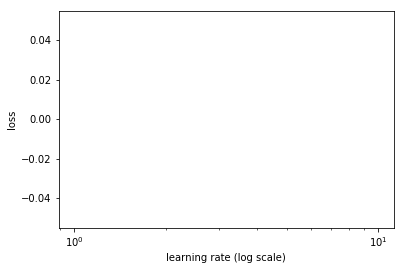

In [74]:
m.lr_find()
m.sched.plot(100)
lr = .001

Because there aren't many rows relative to the batch size, the learning rate graph failed to display any values.

In [75]:
m.fit(lr, 3)

epoch      trn_loss   val_loss                              
    0      0.661121   0.621065  
    1      0.629631   0.5598                               
    2      0.598012   0.495197                    



[array([0.4952])]

In [76]:
m.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                              
    0      0.527548   0.476741  
    1      0.505259   0.453142                              
    2      0.489563   0.437196                              
    3      0.475645   0.424743                              
    4      0.463751   0.415046                              



[array([0.41505])]

In [77]:
m.fit(lr, 3, cycle_len=4, cycle_mult=2 )

epoch      trn_loss   val_loss                              
    0      0.434215   0.40607   
    1      0.424754   0.403849                              
    2      0.42015    0.402517                              
    3      0.413036   0.402023                              
    4      0.413983   0.396546                              
    5      0.411182   0.393191                              
    6      0.402705   0.38569                               
    7      0.398038   0.383176                              
    8      0.395311   0.381589                              
    9      0.390387   0.38143                              
    10     0.386999   0.381318                              
    11     0.384009   0.381316                              
    12     0.385056   0.374358                              
    13     0.380262   0.376583                              
    14     0.376546   0.374407                              
    15     0.374725   0.369065                       

[array([0.36848])]

In [78]:
m.save('titanic_nn_model')

In [79]:
m.load('titanic_nn_model')

## Validation

In [95]:
(x,y1)=m.predict_with_targs()

Predicted vs Validation

In [97]:
(np.argmax(x,axis=1),y1)

(array([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ..., 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0]),
 array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..., 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0]))

In [98]:
y1.shape


(90,)

In [104]:
val = train.iloc[val_idx]
val[['PassengerId','Survived']]
valpred = pd.DataFrame({'PassengerId':val.PassengerId, 'Survived':val.Survived, 'Survived_pred':np.argmax(x,axis=1)})[['PassengerId', 'Survived','Survived_pred']]
valpred.head(10)

,PassengerId,Survived,Survived_pred
801,802,1,1
802,803,1,1
803,804,1,1
804,805,1,0
805,806,0,0
806,807,0,0
807,808,0,0
808,809,0,0
809,810,1,1
810,811,0,0


In [84]:
valpred.loc[valpred.Survived == valpred.Survived_pred].shape

(77, 3)

## Test and Kaggle Submission

In [85]:
np.argmax(m.predict(True), axis =1)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, ..., 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1])

In [103]:
sub = pd.DataFrame({'PassengerId':test.index, 'Survived':np.argmax(m.predict(True), axis =1)})[['PassengerId', 'Survived']]
sub.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [87]:
csv_fn=f'{PATH}/tmp/sub4.csv'
sub.to_csv(csv_fn, index=False)
FileLink(csv_fn)

/home/paperspace/fastai/courses/dl1/data/titanic/tmp/sub4.csv

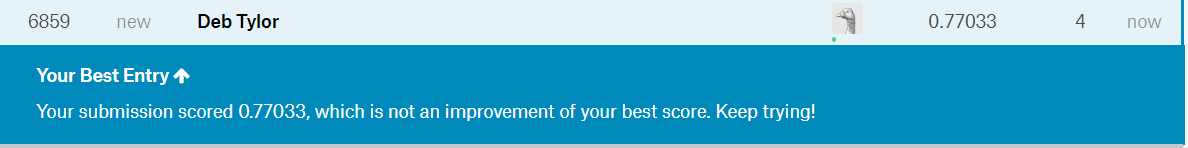


## RF

In [108]:
from sklearn.ensemble import RandomForestRegressor

In [109]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y)

In [110]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

Accuracy of 87% on the validation set using a Random Forest Regressor.

In [139]:
def PredtoClass(a):
    pred_class = []
    for i in range(len(a)):
        if a[i]<.5:
            pred_class.append(0)
        else:
            pred_class.append(1)
    return pred_class
def accuracy(preds, y_val):
    return  sum(1- abs(PredtoClass(preds) - y_val))/len(y_val)

In [141]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, accuracy(preds, y_val)

(0.8133054096609964,
 0.47265045085703417,
 0.42569619049697704,
 0.8666666666666667)

In [142]:
preds_test = m.predict(df_test.values)

In [146]:
sub = pd.DataFrame({'PassengerId':test.index, 'Survived':PredtoClass(preds_test)})[['PassengerId', 'Survived']]
sub.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [147]:
csv_fn=f'{PATH}/tmp/RFsub5.csv'
sub.to_csv(csv_fn, index=False)
FileLink(csv_fn)

/home/paperspace/fastai/courses/dl1/data/titanic/tmp/RFsub5.csv

This random forest submission also received a score of 0.77033, exactly the same as the nn score, despite the 86.7% validation set accuracy.